In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler,  OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import xgboost as xgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mortality/CHAMPS.csv
/kaggle/input/data-dictinary/Data dictiorinary_CHAMPS Project 6.1_decode.pdf


# Loading the Dataset

In [45]:
df=pd.read_csv('/kaggle/input/child-mortality/CHAMPS.csv')
df.head()

,packet_version_id,id_ver_nmb,champs_id,dp_001,dp_002,dp_003,dp_004,dp_005,dp_006,dp_007,...,dpf_012___ch00040,dpf_012___ch00041,dpf_012___ch00042,dpf_012___ch00043,dpf_012___ch01424,dpf_012___ch01875,dpf_012___ch00010,dpf_013,dpf_014,crf_060302_decode_panel_feedback_form_complete
0,ETAA00002_01_01,2.0.0,ETAA00002,5,1,2,3,4.0,5.0,6.0,...,0,0,0,0,0,0,0,Tseyon Tesfaye Clinical,NaN,2
1,ETAA00004_01_02,2.0.0,ETAA00004,5,1,2,3,4.0,5.0,6.0,...,0,0,0,0,0,0,0,"Adugna (SBS team), Tigistu (counselor), Tseyon...",NaN,2
2,ETAA00005_01_02,2.0.0,ETAA00005,5,1,2,3,4.0,5.0,6.0,...,0,0,0,0,0,0,0,"Adugna (SBS team), Tigistu (counselor), Tseyon...",NaN,2
3,ETAA00008_01_04,2.0.0,ETAA00008,5,1,2,3,4.0,5.0,6.0,...,0,0,0,0,0,0,0,"Abdurahman Yonis(HO), Eyoel Taye(counselor), G...",The family leaves in a refugee camp and even t...,2
4,ETAA00009_01_01,2.0.0,ETAA00009,5,18,19,20,21.0,7.0,NaN,...,0,0,0,0,0,0,0,NaN,NaN,0


# Enumerating the columns of the dataset

In [46]:
num_rows, num_columns = df.shape

In [47]:
columns = df.columns.tolist()

In [48]:
print(f'The dataset has {num_rows} rows and {num_columns} columns.')
print('The columns in the dataset are:')
for i, column in enumerate(columns):
    print(f'{i+1}. {column}')

The dataset has 444 rows and 381 columns.
The columns in the dataset are:
1. packet_version_id
2. id_ver_nmb
3. champs_id
4. dp_001
5. dp_002
6. dp_003
7. dp_004
8. dp_005
9. dp_006
10. dp_007
11. dp_008
12. dp_009
13. dp_010
14. dp_011
15. dp_012
16. dp_013
17. dp_153
18. dp_016
19. dp_017
20. dp_154
21. dp_155
22. dp_014
23. dp_108
24. dp_109
25. dp_110
26. dp_111
27. dp_112
28. dp_113
29. dp_114
30. dp_115
31. dp_116
32. dp_117
33. dp_157
34. dp_018
35. dp_019
36. dp_020
37. dp_021
38. dp_022
39. dp_023
40. dp_024
41. dp_025
42. dp_026
43. dp_027
44. dp_156
45. dp_028
46. dp_029
47. dp_030
48. dp_031
49. dp_032
50. dp_033
51. dp_034
52. dp_035
53. dp_036
54. dp_037
55. dp_038
56. dp_039
57. dp_040
58. dp_041
59. dp_042
60. dp_043
61. dp_044
62. dp_045
63. dp_046
64. dp_047
65. dp_048
66. dp_049
67. dp_050
68. dp_051
69. dp_052
70. dp_053
71. dp_054
72. dp_055
73. dp_056
74. dp_057
75. dp_058
76. dp_059
77. dp_060
78. dp_061
79. dp_062
80. dp_063
81. dp_064
82. dp_065
83. dp_066
84. 

# Mapping Old Column Names to New Column Names:

In [49]:
# Step 5: Rename the columns
df = df.rename(columns={
    'champs_id': 'champs_id',
    'dp_013': 'case_type',
    'dp_108': 'underlying_cause',
    'dp_118': 'main_maternal_disease'
})

# Rename values

In [50]:
# Step 6: Rename values
case_type_mapping = {
    'CH00716': 'Stillbirth',
    'CH01404': 'Death in the first 24 hours',
    'CH01405': 'Early Neonate (1 to 6 days)',
    'CH01406': 'Late Neonate (7 to 27 days)',
    'CH00718': 'Infant (28 days to less than 12 months)',
    'CH00719': 'Child (12 months to less than 60 months)'
}

In [51]:
df['case_type'] = df['case_type'].map(case_type_mapping)

#  Show the proportion of null values in each column

In [52]:
null_proportions = df.isnull().mean()
print("Proportion of null values in each column:")    
print(null_proportions)

Proportion of null values in each column:
packet_version_id                                 0.000000
id_ver_nmb                                        0.000000
champs_id                                         0.000000
dp_001                                            0.000000
dp_002                                            0.000000
                                                    ...   
dpf_012___ch01875                                 0.000000
dpf_012___ch00010                                 0.000000
dpf_013                                           0.590090
dpf_014                                           0.603604
crf_060302_decode_panel_feedback_form_complete    0.000000
Length: 381, dtype: float64


# What are the magnitude and proportion of each of the infant underlying cause for child death?

In [53]:
# Calculate the count (magnitude) of each unique value in the 'underlying_cause' column
underlying_cause_counts = df['underlying_cause'].value_counts()

# Calculate the proportion of each unique value in the 'underlying_cause' column
underlying_cause_proportions = df['underlying_cause'].value_counts(normalize=True)

# Combine the counts and proportions into a single DataFrame
underlying_cause_stats = pd.DataFrame({
    'Count': underlying_cause_counts,
    'Proportion': underlying_cause_proportions
})

print("Magnitude and proportion of each underlying cause for child death:")
print(underlying_cause_stats)


Magnitude and proportion of each underlying cause for child death:
                                         Count  Proportion
underlying_cause                                          
Intrauterine hypoxia                       148    0.333333
Birth asphyxia                              33    0.074324
Undetermined                                28    0.063063
Severe acute malnutrition                   24    0.054054
Craniorachischisis                          16    0.036036
...                                        ...         ...
Severe acute malnutrition (Marasmus)         1    0.002252
Portal Hypertension                          1    0.002252
RH isoimmuzation                             1    0.002252
Congenital toxoplasmosis                     1    0.002252
Severe acute malnutrition (KW marasmic)      1    0.002252

[97 rows x 2 columns]


# Calculate the magnitude and proportion of maternal factors contributing to child death

In [54]:
# Calculate the count (magnitude) of each unique value in the 'main_maternal_disease' column
maternal_factors_counts = df['main_maternal_disease'].value_counts()

# Calculate the proportion of each unique value in the 'main_maternal_disease' column
maternal_factors_proportions = df['main_maternal_disease'].value_counts(normalize=True)

# Combine the counts and proportions into a single DataFrame
maternal_factors_stats = pd.DataFrame({
    'Count': maternal_factors_counts,
    'Proportion': maternal_factors_proportions
})

print("Magnitude and proportion of maternal factors contributing to child death:")
print(maternal_factors_stats)


Magnitude and proportion of maternal factors contributing to child death:
                                                    Count  Proportion
main_maternal_disease                                                
Preeclampsia                                           36    0.182741
Twin pregnancy                                         12    0.060914
Fetus and newborn affected by other forms of pl...     11    0.055838
Eclampsia                                               9    0.045685
Fetus and newborn affected by other malpresenta...      5    0.025381
...                                                   ...         ...
Fetus and newborn affected by maternal diabetes         1    0.005076
Fetus and newborn affected by maternal infectio...      1    0.005076
Fetus and newborn affected by multiple pregnanc...      1    0.005076
Fetus and newborn affected by multiple pregnanc...      1    0.005076
Eclampsia/HELLP                                         1    0.005076

[97 rows x 2 co

# Calculate the proportion of child death by case type

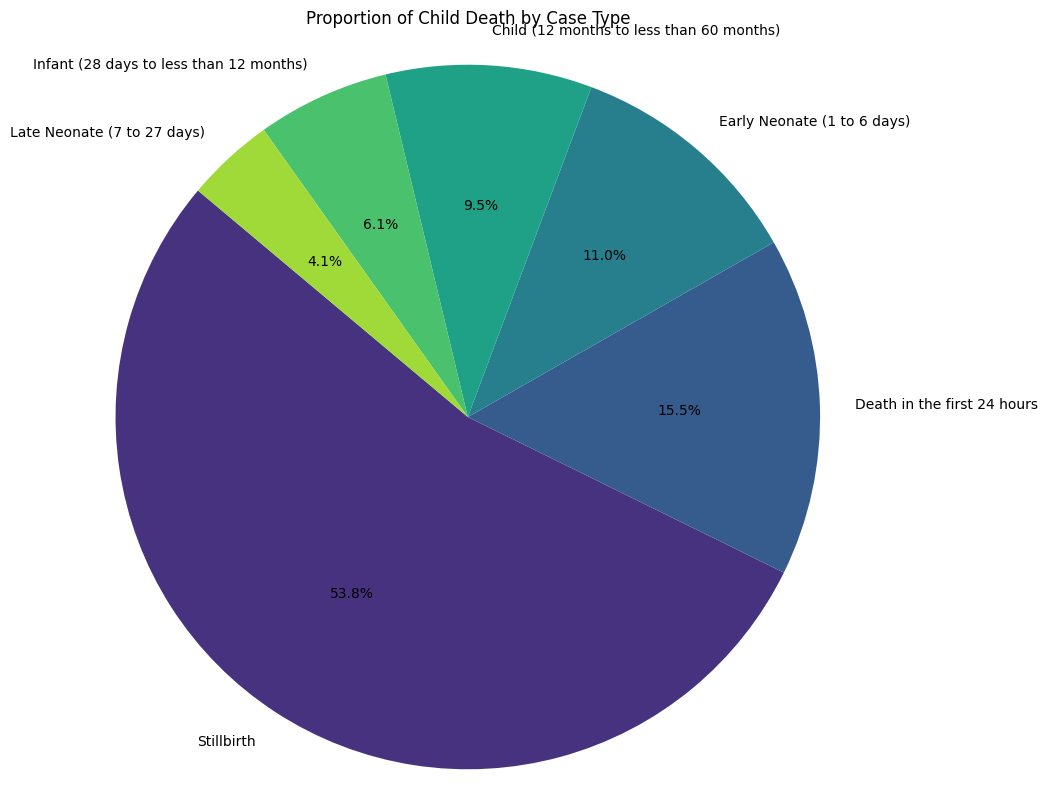

In [55]:
# Calculate the count (magnitude) of each unique value in the 'case_type' column
case_type_counts = df['case_type'].value_counts()

# Calculate the proportion of each unique value in the 'case_type' column
case_type_proportions = df['case_type'].value_counts(normalize=True)

# Combine the counts and proportions into a single DataFrame
case_type_stats = pd.DataFrame({
    'Count': case_type_counts,
    'Proportion': case_type_proportions
})

# Plot the proportions of child death by case type using a pie chart
plt.figure(figsize=(10, 10))
plt.pie(case_type_stats['Proportion'], labels=case_type_stats.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(case_type_stats)))
plt.title('Proportion of Child Death by Case Type')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


# Correlation analysis

In [56]:
# Identify the top three causes of child death
top_causes = df['underlying_cause'].value_counts().nlargest(3).index.tolist()

# Filter dataset to include only these top causes
filtered_df = df[df['underlying_cause'].isin(top_causes)]

In [57]:
filtered_df.head()

,packet_version_id,id_ver_nmb,champs_id,dp_001,dp_002,dp_003,dp_004,dp_005,dp_006,dp_007,...,dpf_012___ch00040,dpf_012___ch00041,dpf_012___ch00042,dpf_012___ch00043,dpf_012___ch01424,dpf_012___ch01875,dpf_012___ch00010,dpf_013,dpf_014,crf_060302_decode_panel_feedback_form_complete
0,ETAA00002_01_01,2.0.0,ETAA00002,5,1,2,3,4.0,5.0,6.0,...,0,0,0,0,0,0,0,Tseyon Tesfaye Clinical,NaN,2
1,ETAA00004_01_02,2.0.0,ETAA00004,5,1,2,3,4.0,5.0,6.0,...,0,0,0,0,0,0,0,"Adugna (SBS team), Tigistu (counselor), Tseyon...",NaN,2
2,ETAA00005_01_02,2.0.0,ETAA00005,5,1,2,3,4.0,5.0,6.0,...,0,0,0,0,0,0,0,"Adugna (SBS team), Tigistu (counselor), Tseyon...",NaN,2
7,ETAA00017_01_02,2.0.0,ETAA00017,5,1,2,3,4.0,5.0,6.0,...,0,0,0,0,0,0,0,"Abdurahman Yonis, Eyoel Taye, Gurmu Fayisa",NaN,2
8,ETAA00018_01_01,2.0.0,ETAA00018,5,1,2,4,5.0,7.0,8.0,...,0,1,0,0,0,0,0,"Sherif Gibrael (HO), Eyoel Taye(counselor), Gu...",the health seeking behavior of the family had ...,2


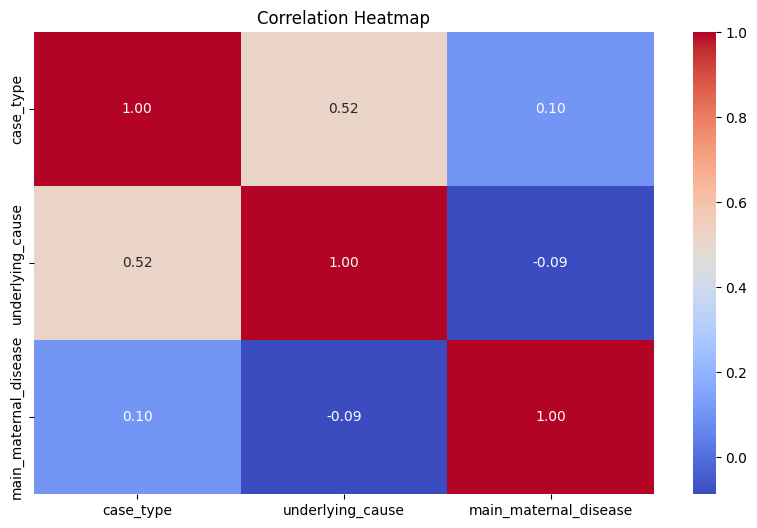

In [58]:
df = df[['case_type', 'underlying_cause', 'main_maternal_disease']]
# Identify the top three causes of child death
top_causes = df['underlying_cause'].value_counts().nlargest(3).index.tolist()

# Filter dataset to include only these top causes
filtered_df = df[df['underlying_cause'].isin(top_causes)]

# Encode categorical variables to numeric
filtered_df_encoded = filtered_df.copy()
filtered_df_encoded['underlying_cause'] = filtered_df_encoded['underlying_cause'].astype('category').cat.codes
filtered_df_encoded['case_type'] = filtered_df_encoded['case_type'].astype('category').cat.codes
filtered_df_encoded['main_maternal_disease'] = filtered_df_encoded['main_maternal_disease'].astype('category').cat.codes
# Calculate the correlation matrix
correlation_matrix = filtered_df_encoded.corr()

# Plot the heat map
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Encoding Catagorical variables

In [59]:

# Filter dataset to include only these top causes
filtered_df = df[df['underlying_cause'].isin(top_causes)]

# Encoding categorical variables
encoder = LabelEncoder()
filtered_df['underlying_cause'] = encoder.fit_transform(filtered_df['underlying_cause'])
filtered_df['case_type'] = encoder.fit_transform(filtered_df['case_type'])
#filtered_df = pd.get_dummies(filtered_df, columns=['underlying_cause', 'main_maternal_disease'])
filtered_df['main_maternal_disease'] = encoder.fit_transform(filtered_df['main_maternal_disease'])

/tmp/ipykernel_34/3241079244.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['underlying_cause'] = encoder.fit_transform(filtered_df['underlying_cause'])
/tmp/ipykernel_34/3241079244.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['case_type'] = encoder.fit_transform(filtered_df['case_type'])
/tmp/ipykernel_34/3241079244.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

# Define features and target variables

In [60]:
# Define features and target
X = filtered_df[['case_type', 'main_maternal_disease']]
y = filtered_df['underlying_cause']

# Split the dataset into training and test sets

In [61]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize classifiers

In [62]:


# Initialize classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(kernel='linear', probability=True),
    'AdaBoost': AdaBoostClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier()
}


# Train the models and collect feature importances

In [63]:
# Train the models and collect feature importances
feature_importances = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    if hasattr(model, 'coef_'):
        importances = model.coef_[0]
    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        raise ValueError(f"Model {model_name} does not have feature importances.")
    
    feature_importances[model_name] = importances

# Create a DataFrame for feature importances
importances_df = pd.DataFrame(feature_importances, index=X.columns)

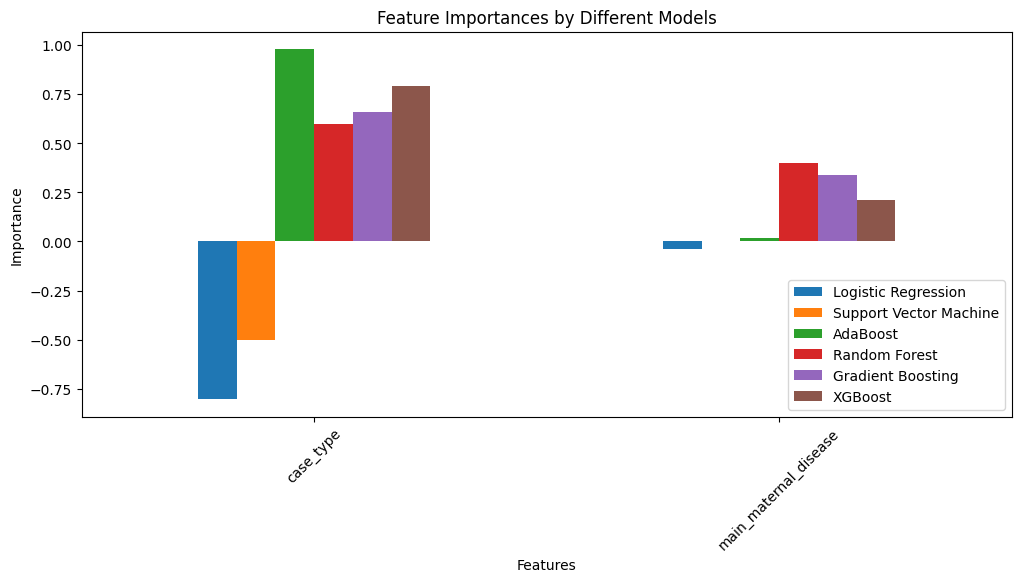

In [75]:
# Plot the feature importances
importances_df.plot(kind='bar', figsize=(12, 5))
plt.title('Feature Importances by Different Models')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

# evaluate the models

In [65]:
# Perform n-fold cross-validation and evaluate the models
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
model_scores = {}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    model_scores[model_name] = cv_scores.mean()
    print(f'{model_name} - Cross-Validation Accuracy: {cv_scores.mean():.4f}')

Logistic Regression - Cross-Validation Accuracy: 0.7324
Support Vector Machine - Cross-Validation Accuracy: 0.7598
AdaBoost - Cross-Validation Accuracy: 0.3947
Random Forest - Cross-Validation Accuracy: 0.7733
Gradient Boosting - Cross-Validation Accuracy: 0.7733
XGBoost - Cross-Validation Accuracy: 0.7598


# Select the best performing model

In [66]:
# Select the best performing model
best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'\nBest Model: {best_model_name}')
print(f'Accuracy on Test Set: {accuracy:.4f}')


Best Model: Random Forest
Accuracy on Test Set: 0.9206


In [67]:
# Create an ensemble of the models
ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('svc', SVC(kernel='linear', probability=True)),
    ('ada', AdaBoostClassifier()),
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('xgb', xgb.XGBClassifier())
], voting='soft')

ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {accuracy_ensemble:.4f}")

Ensemble Model Accuracy: 0.9048


In [68]:
# Evaluate individual models on the test set
individual_accuracies = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    individual_accuracies[model_name] = accuracy

# Display test set accuracies
print("\nTest set accuracies:")
for model_name, accuracy in individual_accuracies.items():
    print(f"{model_name}: {accuracy:.4f}")

# Display the ensemble model accuracy
print(f"\nEnsemble Model Accuracy: {accuracy_ensemble:.4f}")


Test set accuracies:
Logistic Regression: 0.8254
Support Vector Machine: 0.8413
AdaBoost: 0.1429
Random Forest: 0.9206
Gradient Boosting: 0.9206
XGBoost: 0.9048

Ensemble Model Accuracy: 0.9048


# ROC curves

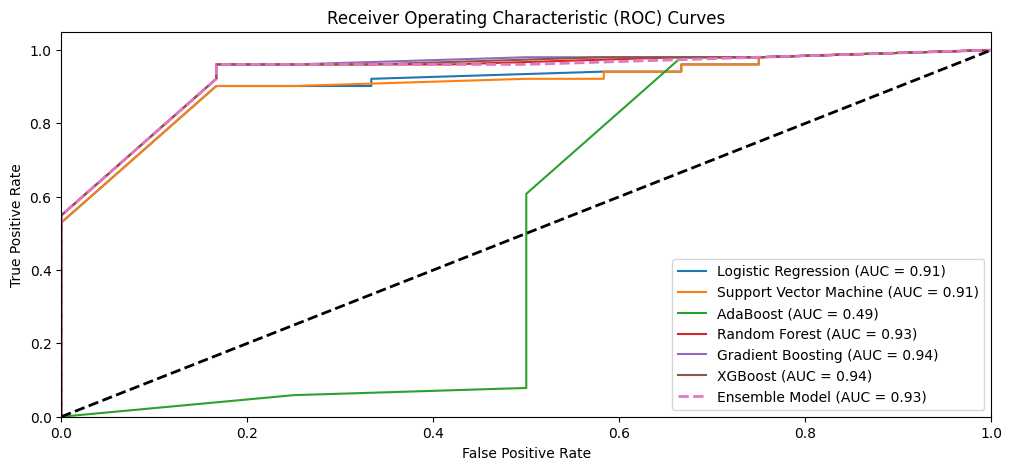

In [74]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

plt.figure(figsize=(12, 5))

# Plot ROC curves for individual models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot ROC curve for ensemble model
y_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_prob_ensemble, pos_label=1)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble Model (AUC = {roc_auc_ensemble:.2f})', linestyle='--', linewidth=2)

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

# Result Visualization

# Plotting feature importance for each model

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


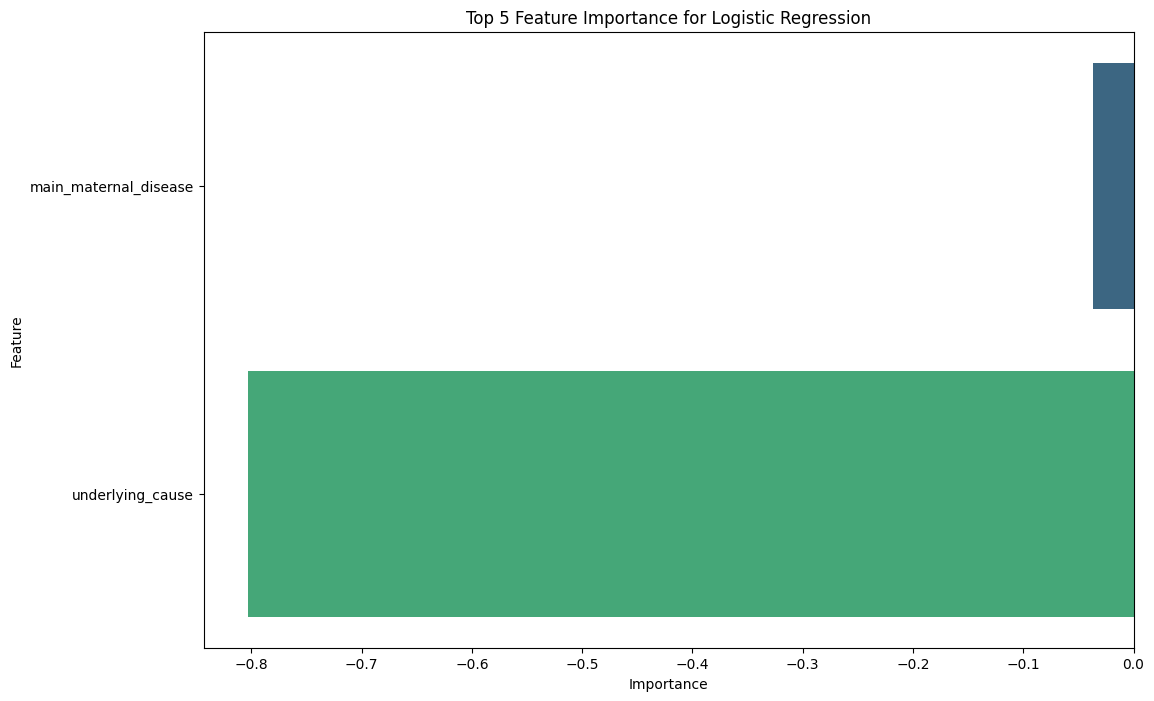

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


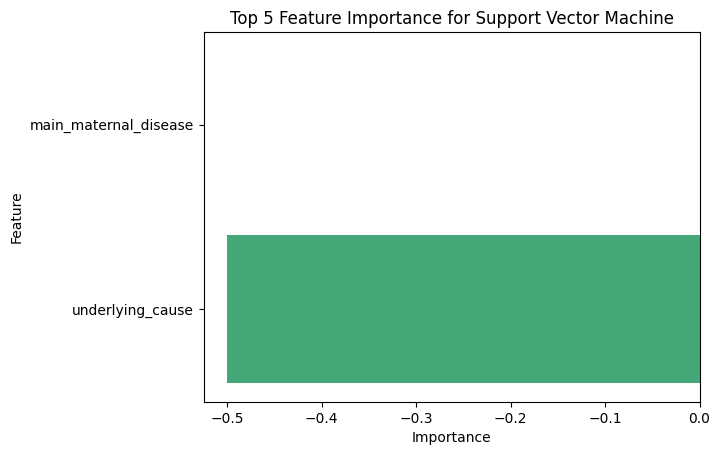

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


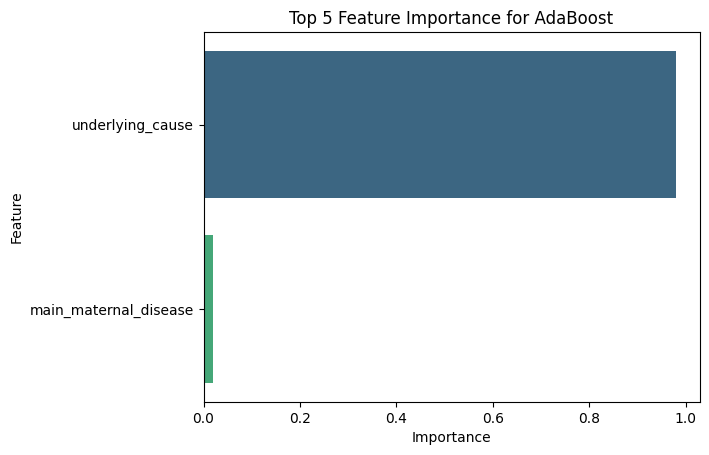

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


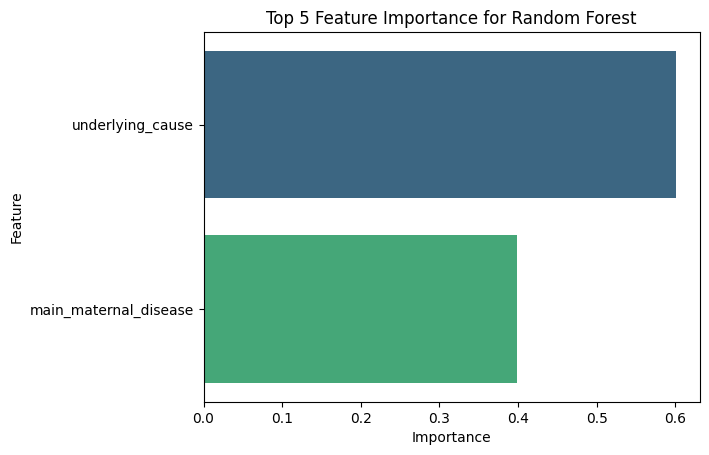

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


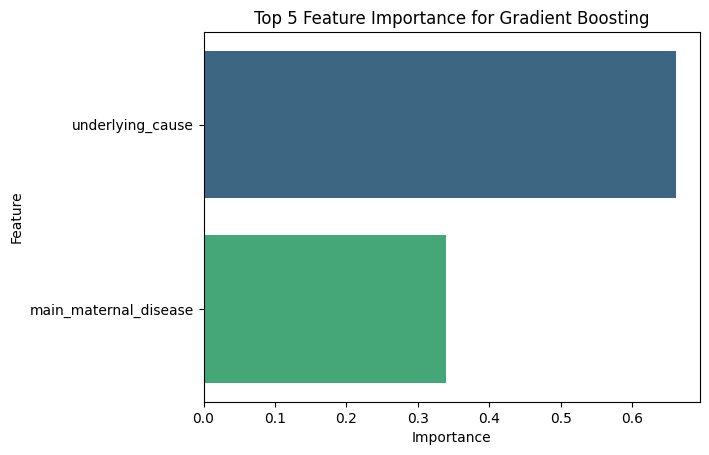

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


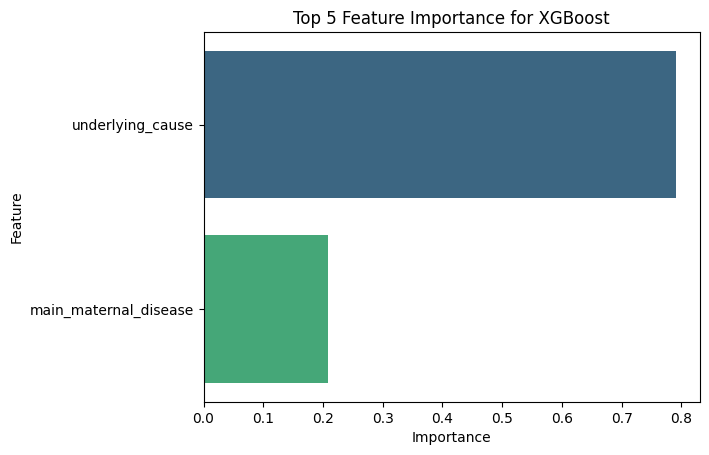

In [70]:
# Assuming you have obtained the feature importance for each model and stored them in a dictionary feature_importance_dict
# Keys of feature_importance_dict are model names and values are lists containing feature importances



# Plotting feature importance for each model
plt.figure(figsize=(12, 8))
for model, feature_importance in feature_importances.items():
    sorted_indices = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)
    sorted_feature_importance = [feature_importance[i] for i in sorted_indices]
    sorted_features = [df.columns[1:][i] for i in sorted_indices]
    sns.barplot(x=sorted_feature_importance[:5], y=sorted_features[:5], palette="viridis")
    plt.title(f"Top 5 Feature Importance for {model}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()


# top five infant underlying causes

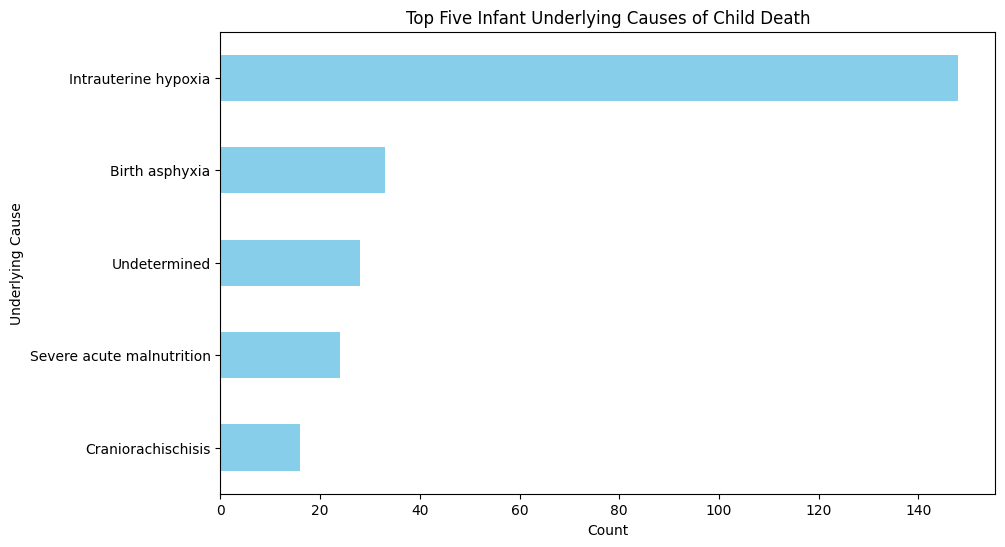

In [71]:
# Assuming you have a DataFrame or Series containing the counts of infant underlying causes and stored in top_infant_causes

# Plotting top five infant underlying causes
plt.figure(figsize=(10, 6))
underlying_cause_counts.head().plot(kind="barh", color="skyblue")
plt.title("Top Five Infant Underlying Causes of Child Death")
plt.xlabel("Count")
plt.ylabel("Underlying Cause")
plt.gca().invert_yaxis()
plt.show()


# Top Five Maternal Factors Contributing to Child Death

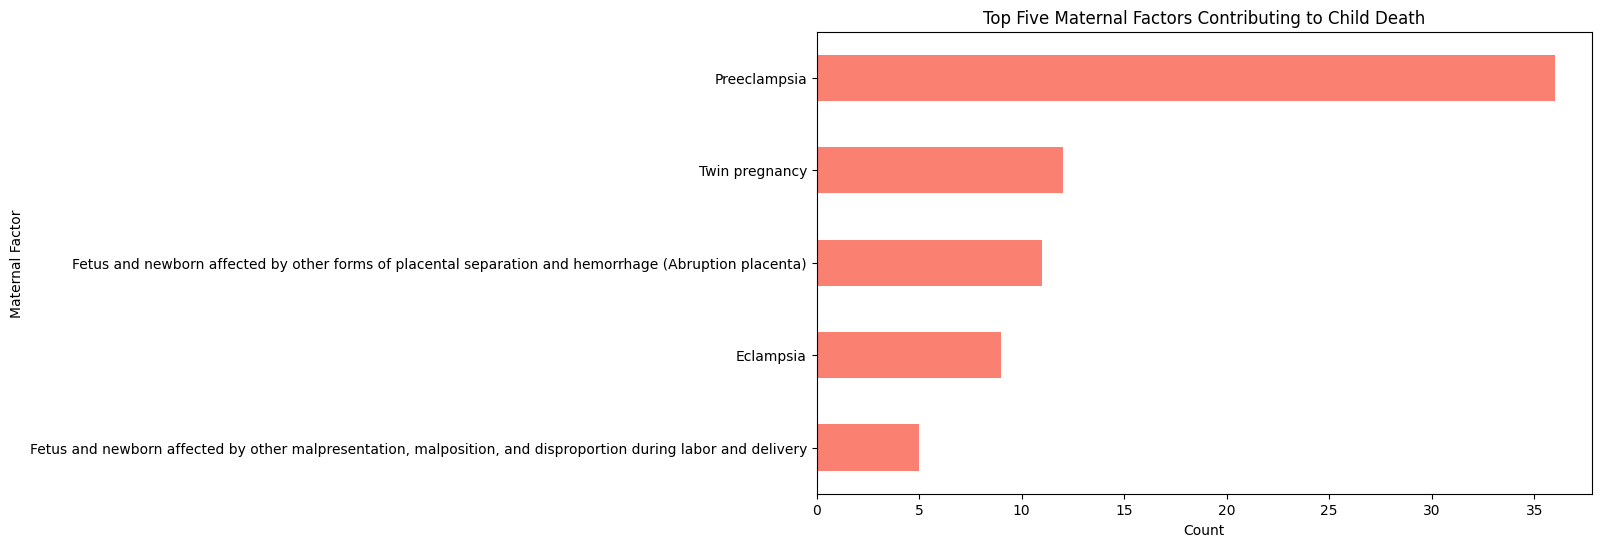

In [72]:
# Assuming you have a DataFrame or Series containing the counts of maternal factors and stored in top_maternal_factors

# Plotting top five maternal factors
plt.figure(figsize=(10, 6))
maternal_factors_counts.head().plot(kind="barh", color="salmon")
plt.title("Top Five Maternal Factors Contributing to Child Death")
plt.xlabel("Count")
plt.ylabel("Maternal Factor")
plt.gca().invert_yaxis()
plt.show()


# Child Death Based on Case Types

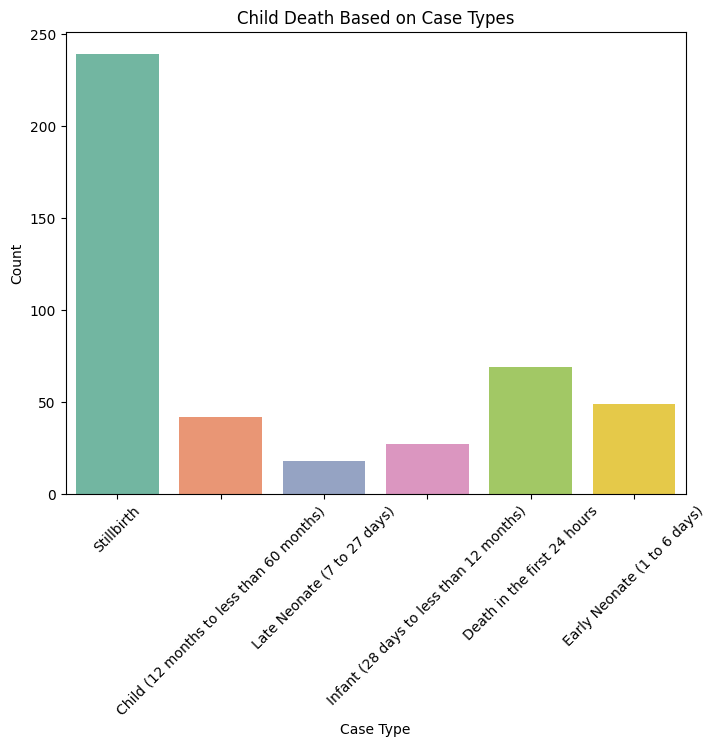

In [73]:
# Plotting child death based on case types
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="case_type", palette="Set2")
plt.title("Child Death Based on Case Types")
plt.xlabel("Case Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()
